In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy, MultiprocessingEvaluator)

from ema_workbench import Samplers

from dike_model_function import DikeNetwork  # @UnresolvedImport

from problem_formulation import get_model_for_problem_formulation

from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

import pickle

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO);

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [4]:
planning_steps

array([0, 1, 2])

In [5]:
uncertainties = dike_model.uncertainties
outcomes = dike_model.outcomes
levers = dike_model.levers

problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [6]:
#for unc in dike_model.uncertainties:
#    print(repr(unc))

In [7]:
#for out in dike_model.outcomes:
#    print(repr(out))

In [8]:
for lev in dike_model.levers:
    print(repr(lev.name))

'0_RfR 0'
'0_RfR 1'
'0_RfR 2'
'1_RfR 0'
'1_RfR 1'
'1_RfR 2'
'2_RfR 0'
'2_RfR 1'
'2_RfR 2'
'3_RfR 0'
'3_RfR 1'
'3_RfR 2'
'4_RfR 0'
'4_RfR 1'
'4_RfR 2'
'EWS_DaysToThreat'
'A.1_DikeIncrease 0'
'A.1_DikeIncrease 1'
'A.1_DikeIncrease 2'
'A.2_DikeIncrease 0'
'A.2_DikeIncrease 1'
'A.2_DikeIncrease 2'
'A.3_DikeIncrease 0'
'A.3_DikeIncrease 1'
'A.3_DikeIncrease 2'
'A.4_DikeIncrease 0'
'A.4_DikeIncrease 1'
'A.4_DikeIncrease 2'
'A.5_DikeIncrease 0'
'A.5_DikeIncrease 1'
'A.5_DikeIncrease 2'


In [9]:
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [10]:
pol = create_policy({'0_RfR 0': 0,
 '1_RfR 0': 0,
 '2_RfR 0': 0,
 '3_RfR 0': 0,
 '4_RfR 0': 0,
 'EWS_DaysToThreat': 0,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 0,},'Upstream dike, downstream rfr')

In [11]:
pol

Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0})

In [12]:
policies = pol
n_exp = 600
   
use_pickle1 = True
if use_pickle1:
    with open('data/SOBOL_results1.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(dike_model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(scenarios=n_exp, policies = pol, uncertainty_sampling=Samplers.SOBOL)
    
    with open('data/SOBOL_results1.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)
        
experiments_sobol, outcomes_sobol = results

In [13]:
outcomes_sobol['Expected Number of Deaths'] = np.nan_to_num(outcomes_sobol['Expected Number of Deaths'], nan = 3.01437703)

In [14]:
deaths_sobol = sobol.analyze(problem, outcomes_sobol['Expected Number of Deaths'],calc_second_order=True, print_to_console=True)
damages_sobol = sobol.analyze(problem, outcomes_sobol['Expected Annual Damage'],calc_second_order=True, print_to_console=True)

                               ST   ST_conf
A.0_ID flood wave shape  0.014463  0.008016
A.1_Bmax                 0.036124  0.017397
A.1_Brate                0.003668  0.006885
A.1_pfail                0.300880  0.040294
A.2_Bmax                 0.003751  0.006785
A.2_Brate                0.003339  0.006746
A.2_pfail                0.035616  0.016600
A.3_Bmax                 0.003405  0.006750
A.3_Brate                0.003332  0.006752
A.3_pfail                0.815033  0.086914
A.4_Bmax                 0.003339  0.006751
A.4_Brate                0.003327  0.006752
A.4_pfail                0.004444  0.006750
A.5_Bmax                 0.003326  0.006752
A.5_Brate                0.003326  0.006752
A.5_pfail                0.019088  0.008310
discount rate 0          0.003326  0.006752
discount rate 1          0.003326  0.006752
discount rate 2          0.003326  0.006752
                               S1   S1_conf
A.0_ID flood wave shape  0.004201  0.015170
A.1_Bmax                 0.01987

In [15]:
Si_filter = {k:deaths_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_deaths = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_deaths['ST-S1'] = Si_df_deaths['ST'] - Si_df_deaths['S1']
Si_df_deaths

,ST,ST_conf,S1,S1_conf,ST-S1
A.0_ID flood wave shape,0.014463,0.008016,0.004201,0.015170,0.010262
A.1_Bmax,0.036124,0.017397,0.019870,0.019814,0.016254
A.1_Brate,0.003668,0.006885,0.002223,0.005670,0.001446
A.1_pfail,0.300880,0.040294,0.185093,0.058402,0.115787
A.2_Bmax,0.003751,0.006785,0.003424,0.005235,0.000327
A.2_Brate,0.003339,0.006746,0.002257,0.004870,0.001082
A.2_pfail,0.035616,0.016600,0.007615,0.020862,0.028001
A.3_Bmax,0.003405,0.006750,0.002893,0.004953,0.000512
A.3_Brate,0.003332,0.006752,0.002392,0.004830,0.000940
A.3_pfail,0.815033,0.086914,0.700122,0.105549,0.114912


In [16]:
# A.1_pfail and A.3_pfail seem to have higher order interactions

In [17]:
## However, the S2 dataframe shows these interactions are not very strong
#S2_deaths_sobol= pd.DataFrame(deaths_sobol['S2'])
#S2_deaths_sobol

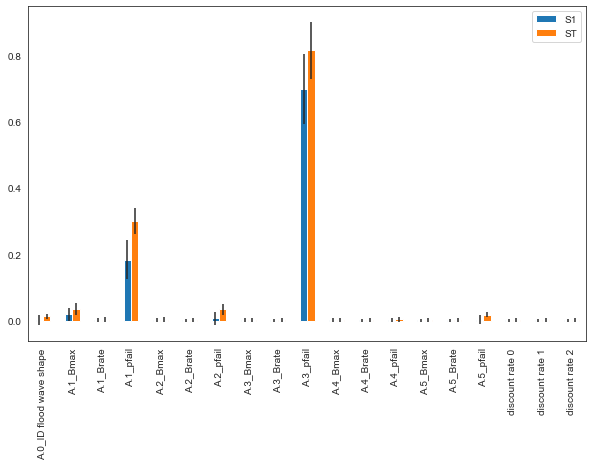

In [25]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df_deaths[['S1','ST']]
err = Si_df_deaths[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(10,8)
fig.subplots_adjust(bottom=0.3)
fig.savefig("sobol_deaths.png", dpi=200)
plt.show()

In [26]:
Si_filter = {k:damages_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_damages = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_damages['ST-S1'] = Si_df_damages['ST'] - Si_df_damages['S1']
Si_df_damages

,ST,ST_conf,S1,S1_conf,ST-S1
A.0_ID flood wave shape,6.912212e-03,2.346756e-03,0.002212,0.008184,0.004700
A.1_Bmax,1.381687e-02,5.708348e-03,0.013079,0.011491,0.000737
A.1_Brate,1.490458e-04,1.787322e-04,0.000392,0.001465,-0.000243
A.1_pfail,7.351578e-01,8.748949e-02,0.687815,0.084501,0.047342
A.2_Bmax,2.129937e-04,1.508122e-04,-0.000045,0.001363,0.000258
A.2_Brate,8.495137e-06,1.357890e-05,-0.000241,0.000286,0.000250
A.2_pfail,2.378937e-02,6.480945e-03,0.011272,0.018014,0.012517
A.3_Bmax,1.064566e-04,6.396596e-05,0.000698,0.001040,-0.000592
A.3_Brate,5.409378e-06,4.206692e-06,-0.000029,0.000214,0.000035
A.3_pfail,2.470685e-01,3.469762e-02,0.211051,0.053653,0.036017


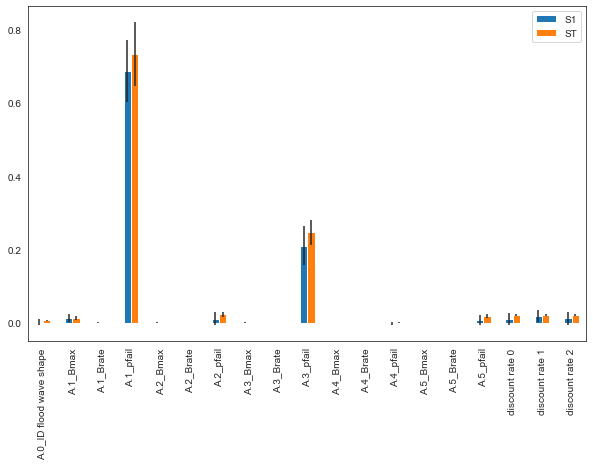

In [27]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df_damages[['S1','ST']]
err = Si_df_damages[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(10,8)
fig.subplots_adjust(bottom=0.3)
fig.savefig("sobol_damages.png", dpi=200)
plt.show()

In [21]:
S2_deaths_sobol= pd.DataFrame(deaths_sobol['S2'])